Epoch 1, Gen Loss: 0.8869, Disc Loss: 1.1731


C:\Users\yeray\AppData\Local\Temp\ipykernel_11084\3958146225.py:114: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_list.append(imageio.imread(os.path.join(output_dir, f'image_at_epoch_{epoch}.png')))


Epoch 2, Gen Loss: 1.0621, Disc Loss: 1.1151
Epoch 3, Gen Loss: 0.9463, Disc Loss: 1.0551
Epoch 4, Gen Loss: 0.8529, Disc Loss: 1.2871
Epoch 5, Gen Loss: 0.9114, Disc Loss: 1.1457
Epoch 6, Gen Loss: 1.0235, Disc Loss: 0.9719
Epoch 7, Gen Loss: 0.8294, Disc Loss: 1.5748
Epoch 8, Gen Loss: 1.1167, Disc Loss: 1.0962
Epoch 9, Gen Loss: 1.1712, Disc Loss: 0.8632
Epoch 10, Gen Loss: 1.0352, Disc Loss: 1.1363
Epoch 11, Gen Loss: 0.8808, Disc Loss: 1.2821
Epoch 12, Gen Loss: 0.7980, Disc Loss: 1.3419
Epoch 13, Gen Loss: 0.9678, Disc Loss: 1.2426
Epoch 14, Gen Loss: 0.9294, Disc Loss: 1.2151
Epoch 15, Gen Loss: 1.4898, Disc Loss: 0.7476
Epoch 16, Gen Loss: 1.4750, Disc Loss: 0.8564
Epoch 17, Gen Loss: 1.4153, Disc Loss: 0.8116
Epoch 18, Gen Loss: 1.1935, Disc Loss: 0.9702
Epoch 19, Gen Loss: 1.4724, Disc Loss: 0.8793
Epoch 20, Gen Loss: 1.6204, Disc Loss: 0.6879
Epoch 21, Gen Loss: 1.6432, Disc Loss: 0.6544
Epoch 22, Gen Loss: 1.7712, Disc Loss: 0.7059
Epoch 23, Gen Loss: 1.6224, Disc Loss: 0.6

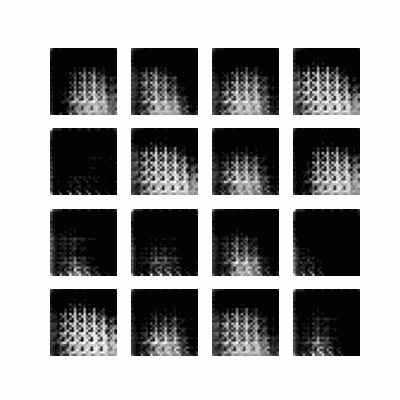

Entrenamiento finalizado. Modelos y GIF guardados en el directorio output.


In [3]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import imageio
from tensorflow.keras import layers
from tensorflow.keras.datasets import fashion_mnist
from IPython.display import display, Image

# Directorios de salida
output_dir = "output"
models_dir = os.path.join(output_dir, "models")
gif_path = os.path.join(output_dir, "training_progress.gif")
os.makedirs(models_dir, exist_ok=True)

# Cargar dataset Fashion MNIST
(train_images, _), (_, _) = fashion_mnist.load_data()
train_images = (train_images.astype(np.float32) - 127.5) / 127.5  # Normalizar entre -1 y 1
train_images = np.expand_dims(train_images, axis=-1)  # Añadir dimensión de canal

BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Crear dataset
dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Crear el generador
def build_generator():
    model = tf.keras.Sequential([
        layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((7, 7, 256)),
        layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

# Crear el discriminador
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1)),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# Crear modelos
generator = build_generator()
discriminator = build_discriminator()

# Definir pérdidas y optimizadores
loss_function = tf.keras.losses.BinaryCrossentropy()
gen_optimizer = tf.keras.optimizers.Adam(1e-4)
disc_optimizer = tf.keras.optimizers.Adam(1e-4)

# Función de pérdida del generador
def generator_loss(fake_output):
    return loss_function(tf.ones_like(fake_output), fake_output)

# Función de pérdida del discriminador
def discriminator_loss(real_output, fake_output):
    real_loss = loss_function(tf.ones_like(real_output), real_output)
    fake_loss = loss_function(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

# Definir función de entrenamiento
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    gen_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss

# Entrenamiento
EPOCHS = 50
seed = tf.random.normal([16, 100])  # Semilla para visualizar progreso
images_list = []

def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
        print(f"Epoch {epoch+1}, Gen Loss: {gen_loss:.4f}, Disc Loss: {disc_loss:.4f}")
        generate_and_save_images(generator, epoch + 1, seed)

# Guardar imágenes generadas
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig, axes = plt.subplots(4, 4, figsize=(4, 4))
    for i, ax in enumerate(axes.flat):
        ax.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        ax.axis('off')
    plt.savefig(os.path.join(output_dir, f'image_at_epoch_{epoch}.png'))
    plt.close()
    images_list.append(imageio.imread(os.path.join(output_dir, f'image_at_epoch_{epoch}.png')))

# Iniciar entrenamiento
train(dataset, EPOCHS)

# Guardar modelos
generator.save(os.path.join(models_dir, 'generator.h5'))
discriminator.save(os.path.join(models_dir, 'discriminator.h5'))

# Crear GIF
imageio.mimsave(gif_path, images_list, duration=0.5)
display(Image(filename=gif_path))

print("Entrenamiento finalizado. Modelos y GIF guardados en el directorio output.")
